In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.utils.metrics as metrics
import src.model.train_rnn as train_recurrent
import src.model.ae as ae
import src.model.rnn as rnn
import src.utils.gau as gaussian
import src.probing.linear_probing as lp
import src.utils.plots as plots


In [22]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
#dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')

In [23]:
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [4]:
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

train_template = train_template.unsqueeze(1).repeat(1, 5, 1, 1)
validation_template = validation_template.unsqueeze(1).repeat(1, 5, 1, 1)
test_template = test_template.unsqueeze(1).repeat(1, 5, 1, 1)


train_dataset = torch.stack((train_template, train_image, train_difference), dim=3  )
validation_dataset = torch.stack((validation_template, validation_difference, validation_difference), dim=3)
test_dataset = torch.stack((test_template, test_image, test_difference), dim=3)

train_template = train_template.unsqueeze(2)  # (samples, 5, 1, 21, 21)
train_image = train_image.unsqueeze(2)        
train_difference = train_difference.unsqueeze(2)  

validation_template = validation_template.unsqueeze(2)
validation_image = validation_image.unsqueeze(2)
validation_difference = validation_difference.unsqueeze(2)

test_template = test_template.unsqueeze(2)
test_image = test_image.unsqueeze(2)
test_difference = test_difference.unsqueeze(2)

# Apilar los tensores a lo largo de la dimensión correcta
train_dataset = torch.cat((train_template, train_image, train_difference), dim=2)
validation_dataset = torch.cat((validation_template, validation_image, validation_difference), dim=2)
test_dataset = torch.cat((test_template, test_image, test_difference), dim=2)

# Crear los conjuntos de datos
train_dataset = TensorDataset(train_dataset, train_class_0)
validation_dataset = TensorDataset(validation_dataset, validation_class_0)
test_dataset = TensorDataset(test_dataset, test_class_0)

# Verificar las dimensiones de los conjuntos de datos
print(train_dataset.tensors[0].shape)  # (samples, 5, 3, 21, 21)
print(validation_dataset.tensors[0].shape)
print(test_dataset.tensors[0].shape)



torch.Size([123227, 5, 3, 21, 21])
torch.Size([600, 5, 3, 21, 21])
torch.Size([600, 5, 3, 21, 21])


In [35]:
train_dataset.tensors[1]
unique, counts = torch.unique(train_dataset.tensors[1], return_counts=True)
print(dict(zip(unique.numpy(), counts.numpy())))

from torch.utils.data import Subset

# Get the indices of each class
class_indices = {cls: (train_dataset.tensors[1] == cls).nonzero(as_tuple=True)[0] for cls in unique}

# Find the minimum number of samples in any class
min_samples = min(len(indices) for indices in class_indices.values())

# Create balanced indices by sampling min_samples from each class
balanced_indices = torch.cat([indices[:min_samples] for indices in class_indices.values()])

# Create a balanced dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)

# Verify the balance
balanced_counts = torch.unique(balanced_train_dataset.dataset.tensors[1][balanced_indices], return_counts=True)
print(dict(zip(balanced_counts[0].numpy(), balanced_counts[1].numpy())))

{np.float32(0.0): np.int64(28092), np.float32(1.0): np.int64(1516), np.float32(2.0): np.int64(93619)}
{np.float32(0.0): np.int64(1516), np.float32(1.0): np.int64(1516), np.float32(2.0): np.int64(1516)}


{np.float32(0.0): np.int64(28092), np.float32(1.0): np.int64(1516), np.float32(2.0): np.int64(93619)}


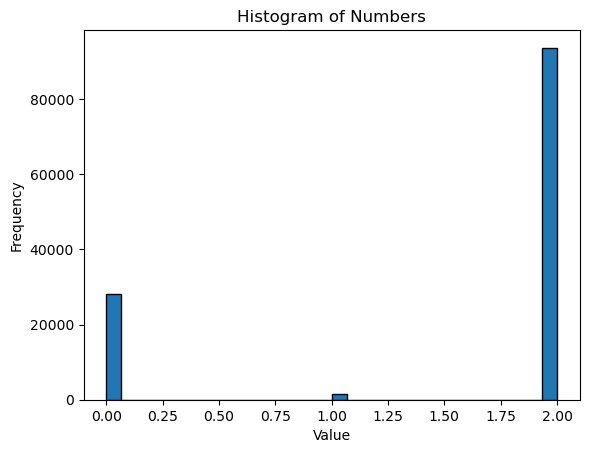

In [33]:
train_dataset.tensors[1]
plt.hist(train_dataset.tensors[1].numpy(), bins=30, edgecolor='black')
plt.title('Histogram of Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [60]:
importlib.reload(train_recurrent)
importlib.reload(rnn)
importlib.reload(ae)

model = ae.AE(50, 3, name="Test_recurrent")
model.load_state_dict(torch.load('models/model_final.pth'))
model.eval()


hidden_dim = 64
num_layers = 2

rnn_model = rnn.RNN('LSTM', 5, 50, hidden_dim, num_layers, 3, name = "Balanced LSTM")

curves, time_i = train_recurrent.train_model(model,
                                             rnn_model,
                                             balanced_train_dataset,
                                             validation_dataset,
                                             test_dataset, 
                                             max_epochs=100, 
                                             batch_size=1,
                                             lr=0.666e-3, 
                                             early_stop=5,
                                             criterion=rnn.loss_function
                                             )

/tmp/ipykernel_2666128/2269794169.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_final.pth'))


Starting training ...


Epoch 6/100 (Early Stop) -- Iteration 27288 - Batch 4547/4548 - Train loss: 0.01702058 - Val loss: 1.15500534Tiempo total de entrenamiento: 184.17 [s]



In [61]:
model = ae.AE(50, 3, name="Test_recurrent")
model.load_state_dict(torch.load('models/model_final.pth'))
model.eval()

# model_rnn = rnn.RNN('RNN', 5, 50, hidden_dim = 5, num_layers = 1, num_class = 3, name = "RNN_test")
# model_rnn.load_state_dict(torch.load('models/rnn_rnn_model_final.pth'))
# model_rnn.eval()

latent_test = model.time_sequence(test_dataset.tensors[0])
prediction_test = rnn_model(latent_test)

/tmp/ipykernel_2666128/3943346888.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_final.pth'))


In [62]:
import torch.nn.functional as F

predicted_class = torch.argmax(F.softmax(prediction_test, dim=1), dim=1)

precision, recall, f1 = metrics.performance_metrics(test_dataset.tensors[1], predicted_class)

print(f"Precision: {precision}",
      f"\nRecall: {recall}",
      f"\nF1: {f1}")

Precision: 0.63415 
Recall: 0.64167 
F1: 0.63299


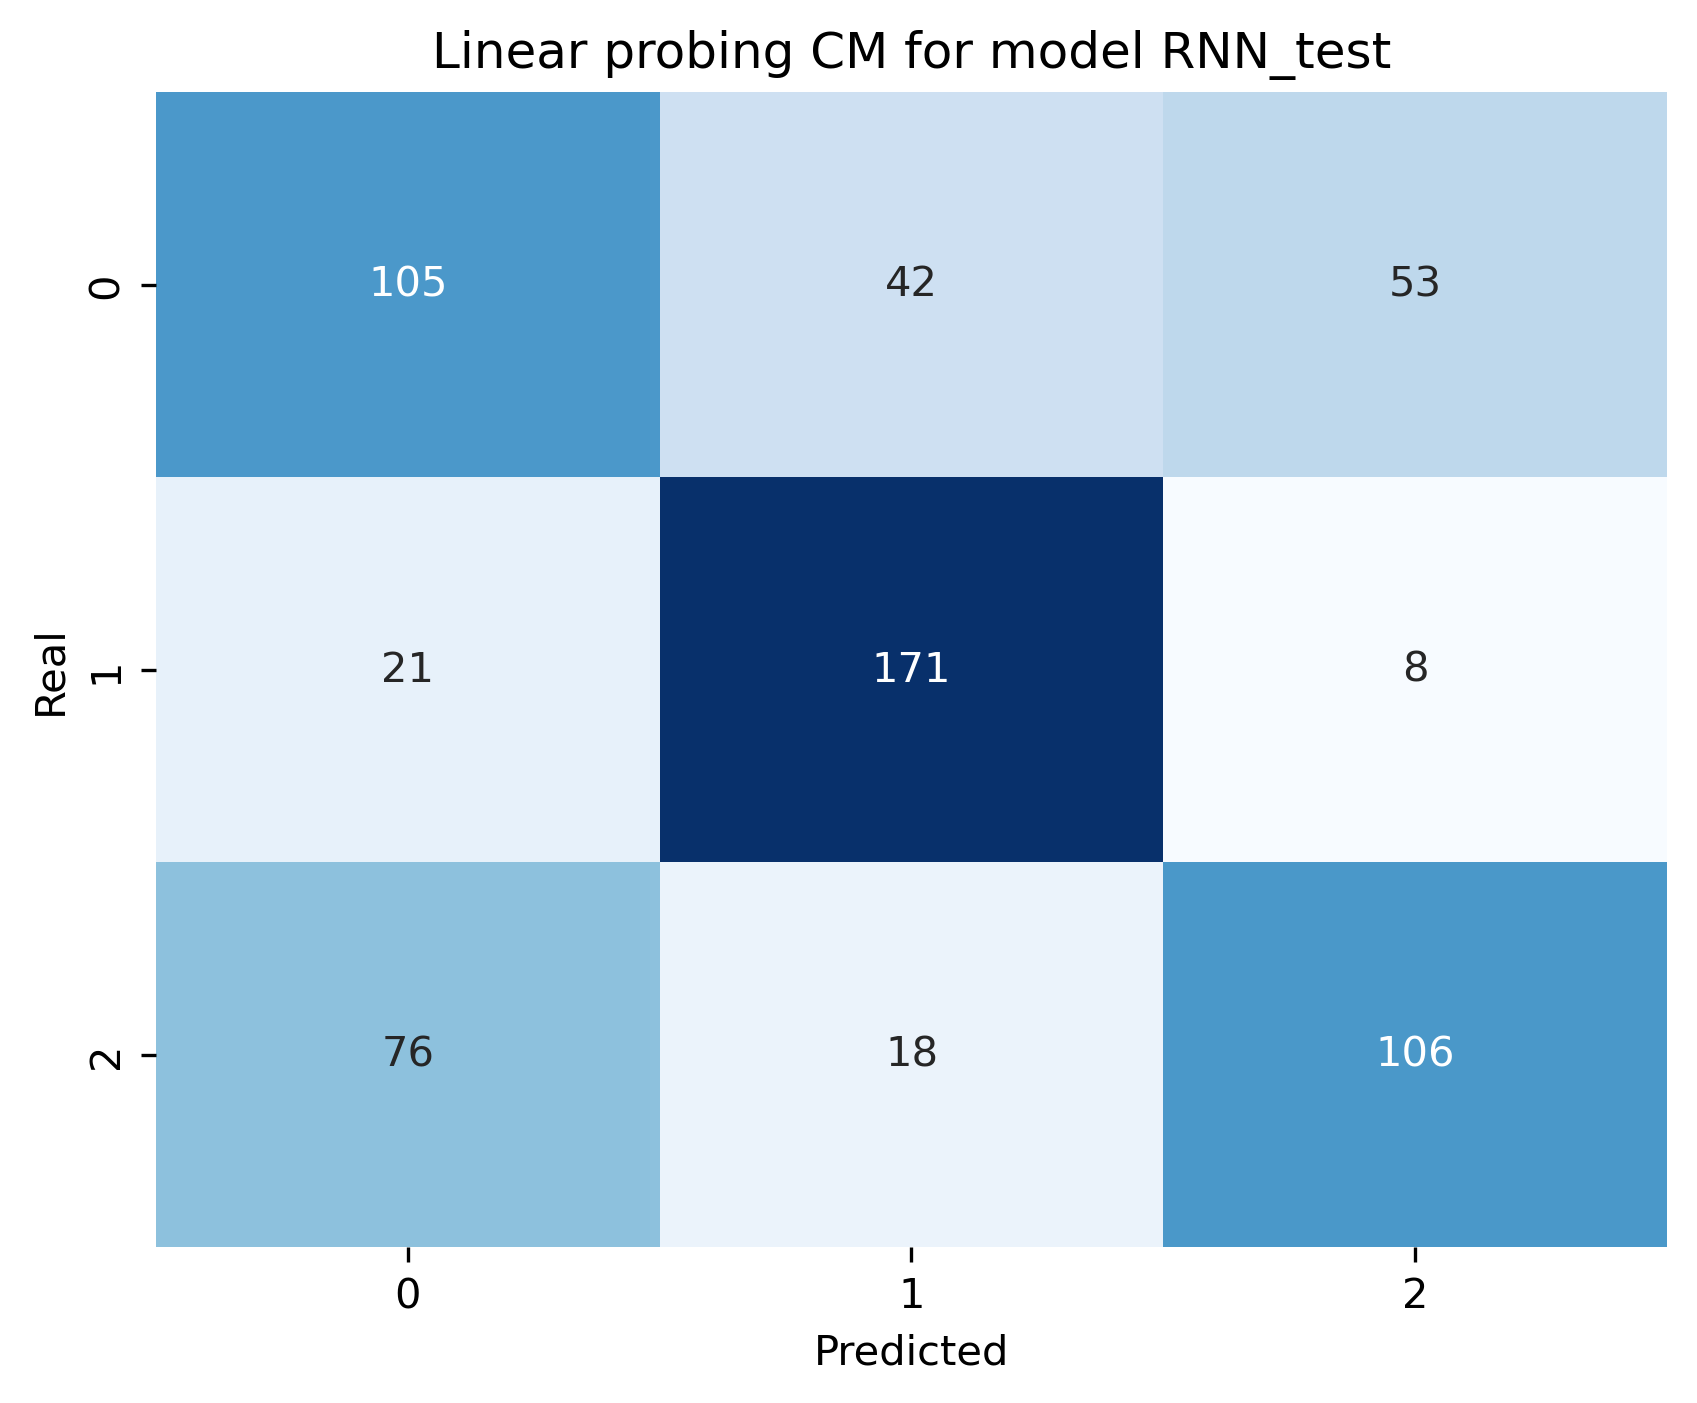

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.tensors[1], predicted_class)

fig = metrics.plot_matrix([model_rnn], [cm])